In [1]:
import os
import os.path as osp
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

sys.path.append("../../")  # Avoid error with importing from src
from src.utils_py.utils import get_each_density_profile
from src.utils_py.profile_approx import _profile_approx_from_array
from src.utils_py.interface import  *

In [2]:
root = os.environ['HOME']
folder = f'{root}/PANDA_exp/example/calcite_decane_tip4p'

---

In [3]:
# Configuration parameters of the system

trajectory_file = osp.join(folder, 'cal_dec_tip4p.xtc')
topology_file = osp.join(folder, 'cal_dec_tip4p.gro')
residue = 'DECAN'
H = 9
l = 2
phi = 0.5
rho_bulk = 3.0896 * 10
interface_type = 'roll'
sl = 200
block_length = 1_000
chunk_length = 1_000
begin_time = 0
time = 40_000
timestep = 2
units = "ps"

In [75]:
# Calculating denisty profiles to each frame of the trajectory

axises, denses = get_each_density_profile(
    trajectory_file,
    topology_file,
    'DECAN',
    200,
    chunk_length,
    begin_time,
    time,
    timestep,
    units
)

Chunk: 100%|██████████| 40/40 [02:12<00:00,  3.31s/it]


In [78]:
# Save axises and denses to the files

np.save('axises', axises)
np.save('denses', denses)

In [4]:
# Load axises and denses from the files, if needed

axises = np.load('axises.npy')
denses = np.load('denses.npy')

In [5]:
# Averaging axises and denses arrays by blocks

blocks_num = axises.shape[0] // block_length

mean_axises = np.zeros((blocks_num, axises.shape[1]))
mean_denses = np.zeros((blocks_num, denses.shape[1]))
for i in range(blocks_num):
    mean_axises[i, :] = np.mean(axises[(i * block_length):((i+1) * block_length), :], axis=0)
    mean_denses[i, :] = np.mean(denses[(i * block_length):((i + 1) *block_length), :], axis=0)

In [6]:
# Calculating contact angle using PANDA algorithm

angles_theta = np.zeros(blocks_num)
angles_alpha = np.zeros(blocks_num)
delta_alpha = np.zeros(blocks_num)

normalized_axises = np.zeros((blocks_num, axises.shape[1]))
normalized_denses = np.zeros((blocks_num, denses.shape[1]))
for i in range(blocks_num):
    axis_i, dens_i, result_theta = _profile_approx_from_array(
        mean_denses[i, :],
        mean_axises[i, :],
        rho_bulk,
        l,
        phi,
        H,
        interface_type='roll',
        extention='theta',
        display=False
    )

    _, _, result_alpha = _profile_approx_from_array(
        mean_denses[i, :],
        mean_axises[i, :],
        rho_bulk,
        l,
        phi,
        H,
        interface_type='roll',
        extention='alpha',
        display=False
    )

    normalized_axises[i, :] = axis_i
    normalized_denses[i, :] = dens_i

    angles_theta[i] = result_theta['theta']
    angles_alpha[i] = result_alpha['theta']
    delta_alpha[i] = result_alpha['delta']

Gradient function does not exist. Using numerical approximation
Gradient function does not exist. Using numerical approximation
Gradient function does not exist. Using numerical approximation
Gradient function does not exist. Using numerical approximation
Gradient function does not exist. Using numerical approximation
Gradient function does not exist. Using numerical approximation
Gradient function does not exist. Using numerical approximation
Gradient function does not exist. Using numerical approximation
Gradient function does not exist. Using numerical approximation
Gradient function does not exist. Using numerical approximation
Gradient function does not exist. Using numerical approximation
Gradient function does not exist. Using numerical approximation
Gradient function does not exist. Using numerical approximation
Gradient function does not exist. Using numerical approximation
Gradient function does not exist. Using numerical approximation
Gradient function does not exist. Using 

---

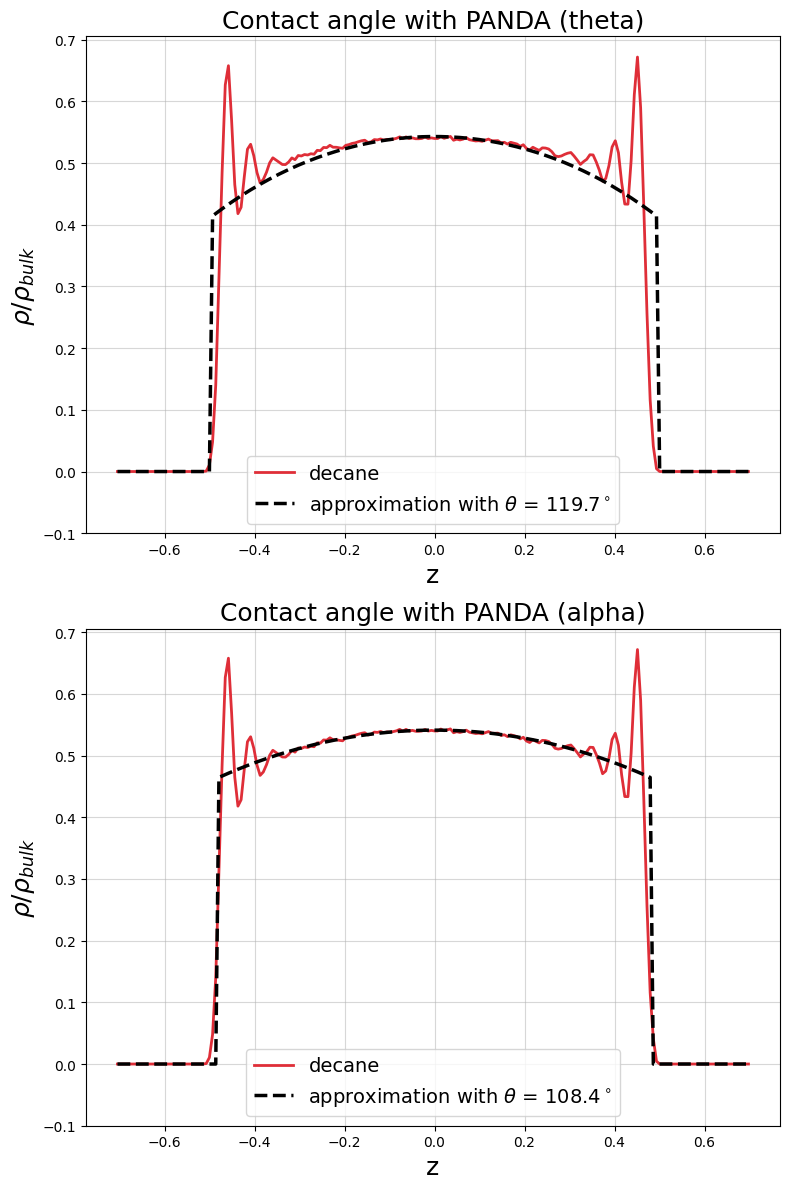

In [7]:
# Visualisation of density profile with different PANDA algorithm version

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 12))

ax1.grid(alpha=0.5)
ax1.plot(
    normalized_axises[-1, :], normalized_denses[-1, :],
    label='decane',
    color='#DF2E38',
    linewidth=2
)

ax1.plot(
    normalized_axises[-1, :], rho_roll_theta(normalized_axises[-1, :], l, phi, angles_theta[-1]),
    label=r'approximation with $\theta$ = {:.1f}$^\circ$'.format(np.rad2deg(angles_theta[-1])),
    color='#000000',
    linewidth=2.5,
    linestyle='dashed'
)

ax2.grid(alpha=0.5)
ax2.plot(
    normalized_axises[-1, :], normalized_denses[-1, :],
    label='decane',
    color='#DF2E38',
    linewidth=2
)

ax2.plot(
    normalized_axises[-1, :], rho_roll_alpha(normalized_axises[-1, :], l, phi, angles_alpha[-1], delta_alpha[-1]),
    label=r'approximation with $\theta$ = {:.1f}$^\circ$'.format(np.rad2deg(angles_alpha[-1])),
    color='#000000',
    linewidth=2.5,
    linestyle='dashed'
)


ax1.set_title('Contact angle with PANDA (theta)', fontsize=18)
ax2.set_title('Contact angle with PANDA (alpha)', fontsize=18)
ax1.set_ylim(bottom=-0.1)
ax2.set_ylim(bottom=-0.1)
ax1.set_xlabel('z', fontsize=18)
ax1.set_ylabel(r'$\rho / \rho_{bulk}$', fontsize=18)
ax1.legend(loc='best', fontsize=14)

ax2.set_xlabel('z', fontsize=18)
ax2.set_ylabel(r'$\rho / \rho_{bulk}$', fontsize=18)
ax2.legend(loc='best', fontsize=14)


plt.tight_layout()
plt.show()

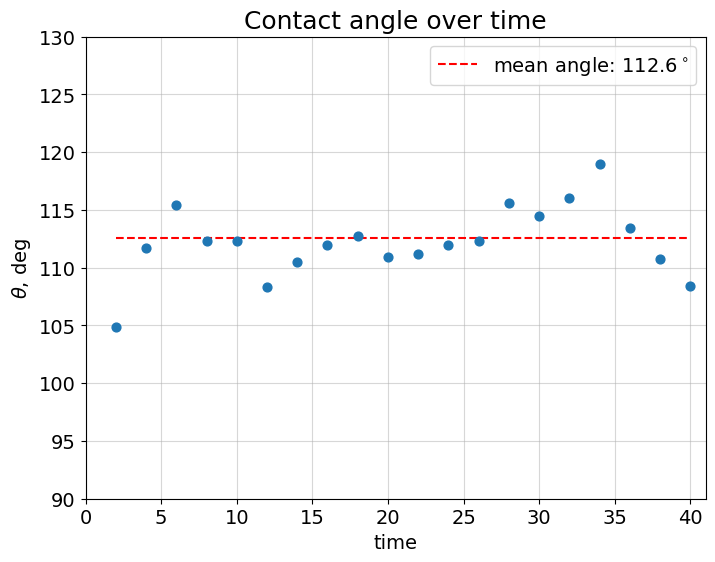

In [8]:
# Visualisation of contact angle over time

plt.figure(figsize=(8, 6))
plt.grid(alpha=0.5, zorder=1)

t = np.arange(2, 41, 2, dtype=int)
plt.scatter(t, np.rad2deg(angles_alpha), s=40, zorder=3)

mean_angle = np.mean(np.rad2deg(angles_alpha)[1:])
plt.hlines(
    mean_angle,
    t[0], t[-1],
    color='red',
    zorder=2,
    linestyles="--",
    label=r"mean angle: {:.1f}$^\circ$".format(mean_angle)
)

plt.title('Contact angle over time', fontsize=18)
plt.xlim(0, 41)
plt.ylim(90, 130)
plt.xlabel('time', fontsize=14)
plt.ylabel(r'$\theta$, deg', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='best', fontsize=14)
plt.show()